In [1]:
import os
import gc
import numpy as np
import tensorflow as tf
from Bio import SeqIO
from utils import preprocessing as pre
from sklearn.model_selection import train_test_split
import models
import pydot
import matplotlib.pyplot as plt

In [2]:

gc.collect()
path = '../Data_Sets/PDB/FASTA'
file_name = 'mask_8.fasta'
dict_ = {'id':[] ,'mask':[],'seq':[], 'mask_bin':[], 'seq_bin':[], 'loss_weight':[], 'seq_int':[]}
count = 0
seq_length = 1024
d_3 = {'H':1/0.372, 'B':1/0.2105, 'C':1/0.4173}
d_8 = {'H': 1/0.36672716,'B': 1/0.01393791 ,'E':1/0.23838632 ,'G':1/0.03821595 ,'I':1/0.00661056 , 'T':1/0.12574269 ,'S':1/0.10994414, '-': 1/0.24329242}
for i, rec in enumerate(SeqIO.parse(os.path.join(path,file_name),'fasta')):
    if i >20000:
        break
    if len(rec.seq)>seq_length:
        continue
    dict_['id'].append(rec.id)
    dict_['mask'].append(rec.description.split('|lcl|')[-1])
    dict_['seq'].append(rec.seq)
    dict_['loss_weight'].append(pre.loss_weight(rec.description.split('|lcl|')[-1], d_8,seq_length))
    dict_['mask_bin'].append(pre.to_binary_mask(pre.mask_padding(rec.description.split('|lcl|')[-1], length=seq_length), typ=8))
    #dict_['seq_bin'].append(pre.zero_padding(pre.to_binary(rec.seq),length=seq_length))
    dict_['seq_int'].append(pre.to_int(rec.seq, max_length=seq_length))

In [3]:
# train test split

X_train, X_test, Y_train, Y_test = train_test_split(np.array(dict_['seq_int'], dtype = np.int8 ), np.array(dict_['mask_bin'], dtype = np.int8), test_size=0.1, random_state=42)
W_train, W_test, _, mask_r = train_test_split(dict_['loss_weight'], dict_['mask'], test_size=0.1, random_state=42)

In [6]:
p = {'max_seq_len': seq_length,
     'num_classes': 8,
     'emb_size': 10,
     'num_filter': [32, 64, 128, 256, 512],
     'kernel_size':[8, 6, 6, 4, 4] ,
     'sampling_stride': [2, 2, 2, 2],
     'pool_size': [2, 2, 2, 2, 2, 2],
     'rate': [0.1, 0.1, 0.1, 0.1, 0.1],
     'l1': [0.0, 0.0, 0.0, 0.0, 0.0],
     'l2': [0.005, 0.005, 0.005, 0.005, 0.001],
     'use_max_pool': False,
     'learning_rate': 1e-4,
    'output_activation': 'softmax'}
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = models.ins_u_net(p)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    add = tf.keras.optimizers.Adam(learning_rate=1e-4,name='Adam')
    opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=False, name='SGD')
    # Callbacks for Adam optimization
    es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=30,restore_best_weights=True)
    lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, verbose=1, mode='auto',
    min_delta=0.0001, min_lr=0.00000001)

    # compiling and fitting with Adam optimizer
    model.compile(optimizer = add, loss = cce, metrics=['accuracy'], sample_weight_mode="temporal")
    his = model.fit(X_train, Y_train, batch_size=64, epochs= 200, callbacks= [ lr], validation_split=0.1, sample_weight = np.array(W_train))
    li1 = model.evaluate(x = X_test, y = Y_test, batch_size=64, verbose=0)

# Callbacks for SGD optimization
#es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20,restore_best_weights=True)
#lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10, verbose=1, mode='auto',
#min_delta=0.0001, min_lr=0.0000001)

#model.compile(optimizer = opt, loss = cce, metrics=['accuracy'], sample_weight_mode="temporal")
#h = model.fit(X_train, Y_train, batch_size=64, epochs= 2, callbacks= [es, lr], validation_split=0.1, sample_weight = np.array(W_train))
#li2 = model.evaluate(x = X_test, y = Y_test, batch_size=64, verbose=0)

print(li1)
#print(li2)
#print(h.history)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
build (None, 64, 256)
build (None, 128, 768)
build (None, 256, 384)
build (None, 512, 192)
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 15044 samples, validate on 1672 samples
Epoch 1/200
INFO:tensorflow:batch_all_reduce: 100 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:batch_all_reduce: 100 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
15044/15044 [==============================] - 43s 3ms/sample - loss: 15.0639 - accuracy: 0.0906 - val_loss: 8.8420 - val_accuracy: 0.0296
Epoch 2/200
15044

15044/15044 [==============================] - 21s 1ms/sample - loss: 2.4456 - accuracy: 0.1421 - val_loss: 2.4165 - val_accuracy: 0.1249
Epoch 49/200
15044/15044 [==============================] - 21s 1ms/sample - loss: 2.4498 - accuracy: 0.1421 - val_loss: 2.4035 - val_accuracy: 0.5062
Epoch 50/200
15044/15044 [==============================] - 21s 1ms/sample - loss: 2.4415 - accuracy: 0.1448 - val_loss: 2.4256 - val_accuracy: 0.1211
Epoch 51/200
15044/15044 [==============================] - 21s 1ms/sample - loss: 2.4461 - accuracy: 0.1451 - val_loss: 2.4060 - val_accuracy: 0.8672
Epoch 52/200
15044/15044 [==============================] - 21s 1ms/sample - loss: 2.4607 - accuracy: 0.1580 - val_loss: 2.3979 - val_accuracy: 0.1382
Epoch 53/200
15044/15044 [==============================] - 21s 1ms/sample - loss: 2.4362 - accuracy: 0.1400 - val_loss: 2.4242 - val_accuracy: 0.1176
Epoch 54/200
15044/15044 [==============================] - 21s 1ms/sample - loss: 2.4703 - accuracy: 0.143

15044/15044 [==============================] - 21s 1ms/sample - loss: 2.2912 - accuracy: 0.1804 - val_loss: 2.3105 - val_accuracy: 0.1423
Epoch 102/200
15044/15044 [==============================] - 21s 1ms/sample - loss: 2.2897 - accuracy: 0.1810 - val_loss: 2.3125 - val_accuracy: 0.6270
Epoch 103/200
15044/15044 [==============================] - 21s 1ms/sample - loss: 2.2891 - accuracy: 0.1858 - val_loss: 2.3115 - val_accuracy: 0.8779
Epoch 104/200
15044/15044 [==============================] - 21s 1ms/sample - loss: 2.2868 - accuracy: 0.1917 - val_loss: 2.3091 - val_accuracy: 0.1361
Epoch 105/200
15044/15044 [==============================] - 21s 1ms/sample - loss: 2.2856 - accuracy: 0.1880 - val_loss: 2.3086 - val_accuracy: 0.1485
Epoch 106/200
15044/15044 [==============================] - 21s 1ms/sample - loss: 2.2847 - accuracy: 0.1882 - val_loss: 2.3280 - val_accuracy: 0.8826
Epoch 107/200
15044/15044 [==============================] - 21s 1ms/sample - loss: 2.2844 - accuracy:

Epoch 154/200
15044/15044 [==============================] - 21s 1ms/sample - loss: 2.2402 - accuracy: 0.2152 - val_loss: 2.2879 - val_accuracy: 0.1405
Epoch 155/200
15044/15044 [==============================] - 21s 1ms/sample - loss: 2.2399 - accuracy: 0.2147 - val_loss: 2.2882 - val_accuracy: 0.1415
Epoch 156/200
15044/15044 [==============================] - 21s 1ms/sample - loss: 2.2390 - accuracy: 0.2127 - val_loss: 2.2876 - val_accuracy: 0.8721
Epoch 157/200
15044/15044 [==============================] - 21s 1ms/sample - loss: 2.2386 - accuracy: 0.2180 - val_loss: 2.2868 - val_accuracy: 0.8693
Epoch 158/200
15044/15044 [==============================] - 21s 1ms/sample - loss: 2.2385 - accuracy: 0.2140 - val_loss: 2.2859 - val_accuracy: 0.1417
Epoch 159/200
15044/15044 [==============================] - 21s 1ms/sample - loss: 2.2385 - accuracy: 0.2136 - val_loss: 2.2874 - val_accuracy: 0.1508
Epoch 160/200
15044/15044 [==============================] - 21s 1ms/sample - loss: 2.23

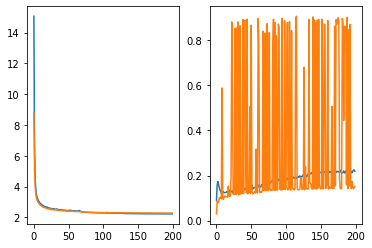

In [7]:

ax1 = plt.subplot(1,2,1)
ax1.plot(his.history['loss'])
ax1.plot(his.history['val_loss'])
ax2 = plt.subplot(1,2,2)
ax2.plot(his.history['accuracy'])
ax2.plot(his.history['val_accuracy'])

In [22]:
model.save_weights('Weights_MaskModel/w_LDataset')

casp_7 0.5103959145879514
casp_8 0.5043761449216365
casp_9 0.5113065831224646
casp_10 0.4882208738286072
casp_11 0.5091328033204645
casp_12 0.496428320490901
casp_13 0.496783416726233
Test 0.6898502665241326


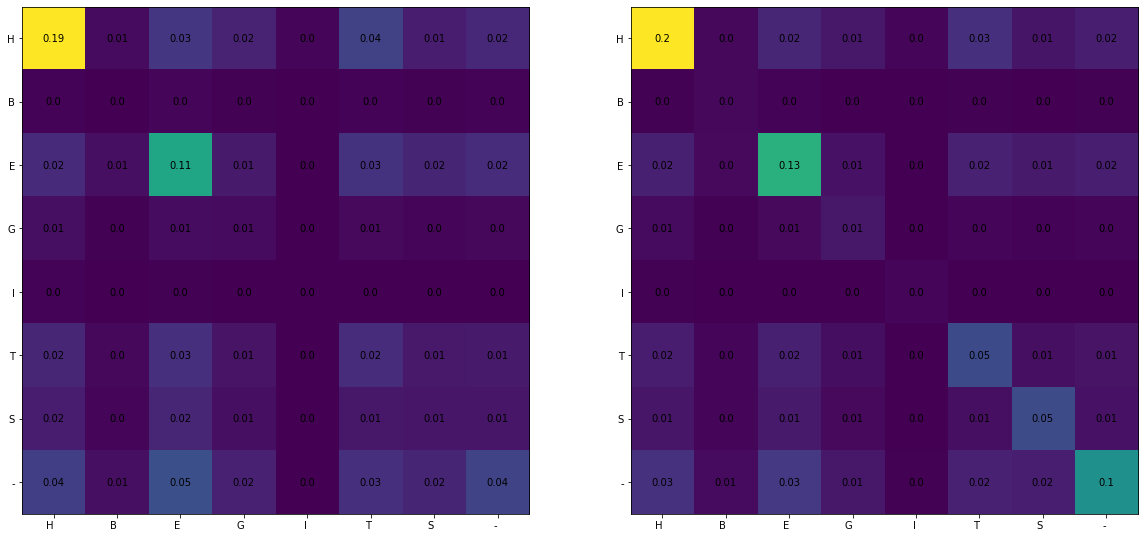

In [8]:
l_8 = True
label_3 = ['B','H','C']
label_8 = ['H','B','E','G','I','T','S','-']
if l_8:
    label = label_8
    typ=8
else:
    label = label_3
    typ=3
path = '../Data_Sets/CASP'
sets = ['casp_7', 'casp_8', 'casp_9','casp_10','casp_11','casp_12','casp_13']
file_name = 'FASTA/mask_8.fasta'
ma = [len(i) for i in mask_r] 
confusion_matrix = np.zeros([p['num_classes'],p['num_classes']])
for h in sets:    
    dict_Casp = {'id':[] ,'mask':[],'seq':[], 'mask_bin':[], 'seq_bin':[], 'seq_int':[]}
    for i, rec in enumerate(SeqIO.parse(os.path.join(path,h,file_name),'fasta')):
        if len(rec.seq)>seq_length:
            continue
        dict_Casp['id'].append(rec.id)
        dict_Casp['mask'].append(rec.description.split('|lcl|')[-1])
        dict_Casp['seq'].append(rec.seq)
        dict_Casp['mask_bin'].append(pre.to_binary_mask(pre.mask_padding(rec.description.split('|lcl|')[-1], length=seq_length), typ=typ))
        dict_Casp['seq_bin'].append(pre.zero_padding(pre.to_binary(rec.seq),length=seq_length))
        dict_Casp['seq_int'].append(pre.to_int(rec.seq, max_length=seq_length))
    
    Y = np.array(dict_Casp['mask_bin'])
    X = np.array(dict_Casp['seq_int'])
    mask_r_casp = [len(n) for n in  dict_Casp['seq']]

    Y_pred = model.predict(X)
    N = 0
    n = 0
    #seq_length = 1

    
    for i, k in enumerate(mask_r_casp):
        tmp = k if k < seq_length else seq_length
        n = n + tmp
        c1 = (np.where(np.round(Y_pred[i,:tmp,:]))[1])
        c2 = (np.where(Y[i,:tmp,:])[1])
        for j in range(c1.size):
                confusion_matrix[c2[j],c1[j]] += 1 
        tmp2 = np.sum(np.round(Y_pred[i,:tmp,:]) * Y[i,:tmp,:])
        N = N + tmp2
    #confusion matrix


    print(h, N/n)
    #seq_length = 1024
    


Y_pred = model.predict(X_test)
N = 0
n = 0
confusion_matrix_test = np.zeros([p['num_classes'],p['num_classes']])
for i, k in enumerate(ma):
    tmp = k if k<seq_length else seq_length
    n = n + tmp
    c1 = (np.where(np.round(Y_pred[i,:tmp,:]))[1])
    c2 = (np.where(Y_test[i,:tmp,:])[1])
    for j in range(c1.size):
            confusion_matrix_test[c2[j],c1[j]] += 1 
    tmp2 = np.sum(np.round(Y_pred[i,:tmp,:]) * Y_test[i,:tmp,:])
    N = N + tmp2
print('Test', N/n)


confusion_matrix = confusion_matrix/np.sum(confusion_matrix)
confusion_matrix_test = confusion_matrix_test/np.sum(confusion_matrix_test)
fig, ax = plt.subplots(figsize=(20, 20))
ax1 = plt.subplot(1,2,1)
im = ax1.imshow(confusion_matrix)
ax1.set_xticks(np.arange(len(label)))
ax1.set_yticks(np.arange(len(label)))
ax1.set_xticklabels(label)
ax1.set_yticklabels(label)
plt.setp(ax1.get_xticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")

ax2 = plt.subplot(1,2,2)
im = ax2.imshow(confusion_matrix_test)
ax2.set_xticks(np.arange(len(label)))
ax2.set_yticks(np.arange(len(label)))
ax2.set_xticklabels(label)
ax2.set_yticklabels(label)
plt.setp(ax2.get_xticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")

for i in range(p['num_classes']):
    for j in range(p['num_classes']):
        text = ax1.text(j, i, round(confusion_matrix[i, j],2),
                       ha="center", va="center", color="k")
        text = ax2.text(j, i, round(confusion_matrix_test[i, j],2),
                       ha="center", va="center", color="k")
